In [2]:
# An S3 Bucket Name to hold the data for demo
data_bucket_name='animals-demo-bax'

# A prefix name inside the S3 bucket containing sub-folders of images (one per label class)
# This bucket will have your cats and dogs as separate species (labels)
dataset_name = 'animals' 

## Setting up the environment
Here we set up the linkage and authentication to AWS services

- The role used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
- A `session` variable that holds some configuration state for interacting with SageMaker from Python and contains some methods for preparing input data
- A reference to the Amazon sagemaker image classification docker image 

More info about the SageMaker built-in Image Classification algorithm here: https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html

In [3]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()
sess = sagemaker.Session()

# Here, we use Sagemakers in-built algorithm for image classification. This algoritm is within a container and 
# is retrieved into the notebook using the following command
training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1


## Preparing data for our model
Before we can train our model, we need to:

- Create some files that will teach SageMaker about the images in each of our classes
- Upload these additional files to S3
- Configure our model to use these files for training and validating

### Find the im2rec.py script on this system
The SageMaker image classifier algorithm needs to know about which images belong to which classes. We provide this data using either LST or RecordIO files. We'll use a python script called `im2rec.py` to create these files.

More info here: https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html#IC-inputoutput

In [4]:
# Find im2rec in our environment and set up some other vars in our environemnt

base_dir='/tmp'

%env BASE_DIR=$base_dir
%env S3_DATA_BUCKET_NAME = $data_bucket_name
%env DATASET_NAME = $dataset_name

import sys,os

suffix='/mxnet/tools/im2rec.py'
im2rec = list(filter( (lambda x: os.path.isfile(x + suffix )), sys.path))[0] + suffix
%env IM2REC=$im2rec

env: BASE_DIR=/tmp
env: S3_DATA_BUCKET_NAME=animals-demo-bax
env: DATASET_NAME=animals
env: IM2REC=/opt/conda/lib/python3.7/site-packages/mxnet/tools/im2rec.py


### Get our training images from S3
In order to create training and validation RecordIO files, we need to download our images to our local filesystem.

In [5]:
# Pull our images from S3
!aws s3 sync s3://$S3_DATA_BUCKET_NAME/$DATASET_NAME $BASE_DIR/$DATASET_NAME --quiet

### Create RecordIO files from our training images
The `im2rec.py` script can create LST files and/or RecordIO files from our training data. 

More info here: https://mxnet.incubator.apache.org/versions/master/faq/recordio.html

In [6]:
%%bash
# Use the IM2REC script to convert our images into RecordIO files

# Clean up our working dir of existing LST and REC files
cd $BASE_DIR
rm *.rec
rm *.lst

# First we need to create two LST files (training and test lists), noting the correct label class for each image
# We'll also save the output of the LST files command, since it includes a list of all of our label classes
echo "Creating LST files"
python $IM2REC --list --recursive --pass-through --test-ratio=0.3 --train-ratio=0.7 $DATASET_NAME $DATASET_NAME > ${DATASET_NAME}_classes

echo "Label classes:"
cat ${DATASET_NAME}_classes

# Then we create RecordIO files from the LST files
echo "Creating RecordIO files"
python $IM2REC --num-thread=4 ${DATASET_NAME}_train.lst $DATASET_NAME
python $IM2REC --num-thread=4 ${DATASET_NAME}_test.lst $DATASET_NAME
ls -lh *.rec

Creating LST files
Label classes:
cats 0
dogs 1
Creating RecordIO files
Creating .rec file from /tmp/animals_train.lst in /tmp
time: 0.07325363159179688  count: 0
Creating .rec file from /tmp/animals_test.lst in /tmp
time: 0.03525996208190918  count: 0
-rw-r--r-- 1 root root  69M Aug  5 17:57 animals_test.rec
-rw-r--r-- 1 root root 164M Aug  5 17:57 animals_train.rec


### Upload our training and test data RecordIO files so we can train with them
Now that we have our training and test .rec files, we upload them to S3 so SageMaker can use them for training

In [7]:
# Upload our train and test RecordIO files to S3 in the bucket that our sagemaker session is using
bucket = sess.default_bucket()

s3train_path = 's3://{}/{}/train/'.format(bucket, dataset_name)
s3validation_path = 's3://{}/{}/validation/'.format(bucket, dataset_name)

# Clean up any existing data
!aws s3 rm s3://{bucket}/{dataset_name}/train --recursive
!aws s3 rm s3://{bucket}/{dataset_name}/validation --recursive

# Upload the rec files to the train and validation channels
!aws s3 cp /tmp/{dataset_name}_train.rec $s3train_path
!aws s3 cp /tmp/{dataset_name}_test.rec $s3validation_path

delete: s3://sagemaker-us-east-1-567669566640/animals/train/animals_train.rec
delete: s3://sagemaker-us-east-1-567669566640/animals/validation/animals_test.rec
upload: ../tmp/animals_train.rec to s3://sagemaker-us-east-1-567669566640/animals/train/animals_train.rec
upload: ../tmp/animals_test.rec to s3://sagemaker-us-east-1-567669566640/animals/validation/animals_test.rec


### Configure the data for our model training to use
Finally, we tell SageMaker where to find these RecordIO files to use for training

In [8]:
train_data = sagemaker.inputs.TrainingInput(
    s3train_path, 
    distribution='FullyReplicated', 
    content_type='application/x-recordio', 
    s3_data_type='S3Prefix'
)

validation_data = sagemaker.inputs.TrainingInput(
    s3validation_path, 
    distribution='FullyReplicated', 
    content_type='application/x-recordio', 
    s3_data_type='S3Prefix'
)

data_channels = {'train': train_data, 'validation': validation_data}
data_channels

{'train': <sagemaker.inputs.TrainingInput at 0x7f0ae612c190>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7f0ae612c210>}

## Training
Now it's time to train our model!

### Create an image classifier object with some base configuration
More info here: https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.Estimator

In [9]:
s3_output_location = 's3://{}/{}/output'.format(bucket, dataset_name)

image_classifier = sagemaker.estimator.Estimator(
    training_image,
    role, 
    instance_count=1, 
    instance_type='ml.p3.2xlarge',
    output_path=s3_output_location,
    sagemaker_session=sess
)

### Set some training hyperparameters

Finally, before we train, we provide some additional configuration parameters for the training.

More info here: https://docs.aws.amazon.com/sagemaker/latest/dg/IC-Hyperparameter.html

In [10]:
num_classes=! ls -l {base_dir}/{dataset_name} | wc -l
num_classes=int(num_classes[0]) - 1
print(num_classes)

num_training_samples=! cat {base_dir}/{dataset_name}_train.lst | wc -l
num_training_samples = int(num_training_samples[0])
print(num_training_samples)

# Learn more about the Sagemaker built-in Image Classifier hyperparameters here: https://docs.aws.amazon.com/sagemaker/latest/dg/IC-Hyperparameter.html

# These hyperparameters we won't want to change, as they define things like
# the size of the images we'll be sending for input, the number of training classes we have, etc.
base_hyperparameters=dict(
    use_pretrained_model=1,
    image_shape='3,150,150',
    num_classes=num_classes,
    num_training_samples=num_training_samples,
)

# These are hyperparameters we may want to tune, as they can affect the model training success:
hyperparameters={
    **base_hyperparameters, 
    **dict(
        learning_rate=0.001,
        mini_batch_size=5,
    )
}


image_classifier.set_hyperparameters(**hyperparameters)

hyperparameters

2
846


{'use_pretrained_model': 1,
 'image_shape': '3,150,150',
 'num_classes': 2,
 'num_training_samples': 846,
 'learning_rate': 0.001,
 'mini_batch_size': 5}

### Start the training
Train our model!

This will take some time because it's provisioning a new container runtime to train our model, then the actual training happens, then the trained model gets uploaded to S3 and the container is shut down.

More info here: https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.Estimator.fit

In [11]:
%%time

import time
now = str(int(time.time()))
training_job_name = 'IC-' + dataset_name.replace('_', '-') + '-' + now

image_classifier.fit(inputs=data_channels, job_name=training_job_name, logs=True)

job = image_classifier.latest_training_job
print(job)
model_path = f"{base_dir}/{job.name}"

print(f"\n\n Finished training! The model is available for download at: {image_classifier.output_path}/{job.name}/output/model.tar.gz")

2022-08-05 17:58:12 Starting - Starting the training job...
2022-08-05 17:58:37 Starting - Preparing the instances for trainingProfilerReport-1659722292: InProgress
.........
2022-08-05 18:00:08 Downloading - Downloading input data
2022-08-05 18:00:08 Training - Downloading the training image...........Docker entrypoint called with argument(s): train
[08/05/2022 18:01:57 INFO 139804867106624] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[08/05/2022 18:01:57 INFO 139804867106624] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'image_shape': '3,150,150', 'learning_rate': '0.0

## Deploy the trained model
Once a model has been trained, we can use the same `image_classifier` object to create a deployed, fully-managed endpoint.}

More info here: https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.Estimator.deploy

In [2]:
%%time
# Deploying a model to an endpoint takes a few minutes to complete


deployed_endpoint = image_classifier.deploy(
    initial_instance_count = 1,
    instance_type = 'ml.t2.medium'
)

NameError: name 'image_classifier' is not defined

<h2> Real time inference with an image </h2>
<p> This is optional. Work in progress </p>


In [13]:
# test image
from IPython.display import Image

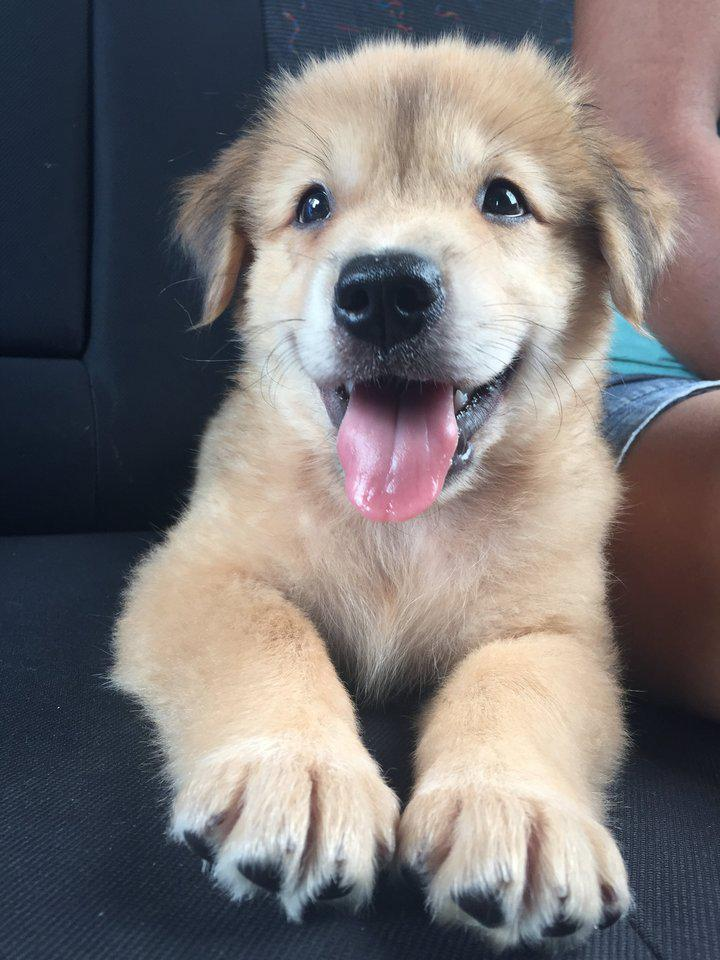

In [14]:
file_name='test_dog/test8.jpg'
Image(file_name)

In [15]:
import json
import numpy as np
import boto3

runtime = boto3.Session().client(service_name="runtime.sagemaker")

with open(file_name, "rb") as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(
    EndpointName='image-classification-2022-07-23-20-02-27-006', ContentType="application/x-image", Body=payload
)
result = response["Body"].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)

object_categories = [
    'cats',
    'dogs'
]
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))
infer = result[index]
print(infer)


Result: label - dogs, probability - 0.9999748468399048
0.9999748468399048


<h2>Generate inferences through a React app - OPTIONAL</h2>

<h4>Follow this link to install node and npm on your machine. MacOS and Windows installation process is listed<h3>
<h5>https://radixweb.com/blog/installing-npm-and-nodejs-on-windows-and-mac</h5>

## Setting up the environment
Here we set up the linkage and authentication to AWS services

- <i>npm install</i>
- <i>amplify init</i>
    <ul>
    <li>Enter a name for the project: sagemaker-inference</li>
    <li>Initialize the project with the above configuration: Y</li>
    <li> Select the authentication method you want to use: AWS Profile</li>
    <li>Please choose the profile you want to use: default(if available)</li>
    </ul>
    
    
    Note: Please wait till AWS Cloudformation deploys the project

- <i>amplify add api</i> 
    <ul>
    <li>Select from one of the below mentioned services: REST</li>
    <li>Provide a friendly name for your resource to be used as a label for this category in the project: Pick any random name</li>
    <li>Provide a path (e.g., /book/{isbn}): /classify</li>
    <li>Choose a Lambda source: Create a new Lambda function</li>
    <li>Provide an AWS Lambda function name: provide any name</li>
    <li>Choose the runtime that you want to use: NodeJS</li>
    <li>Choose the function template that you want to use: Serverless ExpressJS function (Integration with API Gateway)</li>
    <li>Do you want to configure advanced settings?: N</li>
    <li>Do you want to edit the local lambda function now?: Y</li>
    <li>Choose your default editor: Choose any editor you are comfortable with. I picked Visual Studio code. This will open the editor for you with a base app.js file. Add the contents of lambda/app.js from this git source to the file displayed by the editor</li>
    <li> Restrict API access: N</li>
    <li>Do you want to add another path?: N</li>
    </ul>
    
    Note: Wait till all resources are added by amplify
- <i>amplify push</i>
    
- <i>amplify env pull</i>
- Find the IAM role created by Amplify to run the Lambda function -- look in sagemaker-inference/amplify/backend/function/<<your_function_name>>/*-cloudformation-template.json for the role name.
- In the AWS IAM console, edit the role from the step above and add the following policy to it (or copy just the statement and add it to the existing lambdaexecution policy):

```{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "logs:CreateLogGroup",
                "logs:CreateLogStream",
                "logs:PutLogEvents",
                "sagemaker:InvokeEndpoint"
            ],
            "Resource": "arn:aws:logs:us-east-1:567669566640:log-group:/aws/lambda/<<Your IAM role>>:log-stream:*",
            "Effect": "Allow"
        }
    ]
}
 ```

- npm start

Wait for the UI to load into the browser

Here's a **cat** for you <img src="cards_0.jpg" width=800 height=800 />